In [39]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
from pathlib import Path

import numpy as np

from wufam.data.prepare_data import read_kf_data
from wufam.config.trading_config import TradingConfig
from wufam.dataset import Dataset
from wufam.strategies.optimization_data import TrainingData, PredictionData
from wufam.metrics.metrics import calc_sharpe

PATH = Path("../data/kf_data")
START = "1970-01-01"
END = "2024-12-31"
DATASET = Dataset.BM_25
WEIGHTING = "value_weighted"

## 1.1

In [41]:
portfolios_total_r, portfolios_xs_r, factors_df, rf = read_kf_data(
    portfolios_filename=PATH / DATASET,
    factors_filename=PATH / Dataset.FACTORS,
    start_date=START,
    end_date=END,
    weighting=WEIGHTING,
)

## 1.2

In [42]:
from wufam.strategies.heuristics.equally_weighted import EWStrategy
from wufam.strategies.estimated.mean_var import MeanVariance
from wufam.strategies.estimated.min_var import MinVariance

trading_config = TradingConfig(total_exposure=1)

ew_strategy = EWStrategy()

In [43]:
from wufam.estimation.mean.sample_mu_estimator import SampleMuEstimator
from wufam.estimation.covariance.sample_cov_estimator import SampleCovEstimator

mv_strategy = MeanVariance(
    mu_estimator=SampleMuEstimator(),
    cov_estimator=SampleCovEstimator(),
    trading_config=trading_config,
    window_size=None,
)

In [44]:
from wufam.estimation.covariance.shrinkage.lw_cv_cov_estimator import (
    LedoitWolfCVCovEstimator,
)

# trading_config_min_var = TradingConfig(total_exposure=1, min_exposure=0.0)

min_var_strategy = MinVariance(
    cov_estimator=LedoitWolfCVCovEstimator(alphas=np.linspace(0.0, 1.0, 100)),
    # cov_estimator=LedoitWolfCVCovEstimator(),
    # trading_config=trading_config_min_var,
    trading_config=trading_config,
    window_size=None,
)

In [45]:
training_data = TrainingData(
    simple_excess_returns=portfolios_xs_r,
)

ew_strategy.fit(training_data)
mv_strategy.fit(training_data)
min_var_strategy.fit(training_data)

In [46]:
prediction_data = PredictionData()

ew_weights = ew_strategy(prediction_data)
mv_weights = mv_strategy(prediction_data)
min_var_weights = min_var_strategy(prediction_data)

In [47]:
ew_weights.head()

,SMALL LoBM,ME1 BM2,ME1 BM3,ME1 BM4,SMALL HiBM,ME2 BM1,ME2 BM2,ME2 BM3,ME2 BM4,ME2 BM5,...,ME4 BM1,ME4 BM2,ME4 BM3,ME4 BM4,ME4 BM5,BIG LoBM,ME5 BM2,ME5 BM3,ME5 BM4,BIG HiBM
0,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,...,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04


In [48]:
mv_weights.head()

,SMALL LoBM,ME1 BM2,ME1 BM3,ME1 BM4,SMALL HiBM,ME2 BM1,ME2 BM2,ME2 BM3,ME2 BM4,ME2 BM5,...,ME4 BM1,ME4 BM2,ME4 BM3,ME4 BM4,ME4 BM5,BIG LoBM,ME5 BM2,ME5 BM3,ME5 BM4,BIG HiBM
0,-2.381125,0.849035,-0.057197,1.172596,1.427765,-0.223478,0.452104,-0.070424,-0.30162,-0.477851,...,0.788624,-0.224345,-0.16951,0.469953,-0.027964,0.426492,0.28415,0.065037,-0.743579,-0.07405


In [49]:
min_var_weights.head()

,SMALL LoBM,ME1 BM2,ME1 BM3,ME1 BM4,SMALL HiBM,ME2 BM1,ME2 BM2,ME2 BM3,ME2 BM4,ME2 BM5,...,ME4 BM1,ME4 BM2,ME4 BM3,ME4 BM4,ME4 BM5,BIG LoBM,ME5 BM2,ME5 BM3,ME5 BM4,BIG HiBM
0,-0.171595,0.042299,0.227452,0.334261,0.536398,-0.274976,-0.135622,-0.007164,0.048777,-0.409153,...,0.07568,0.154947,0.045825,0.183952,-0.192568,0.234858,0.22352,0.155274,0.023849,-0.160971


In [50]:
min_var_strategy.cov_estimator.best_alpha

np.float64(0.030303030303030304)

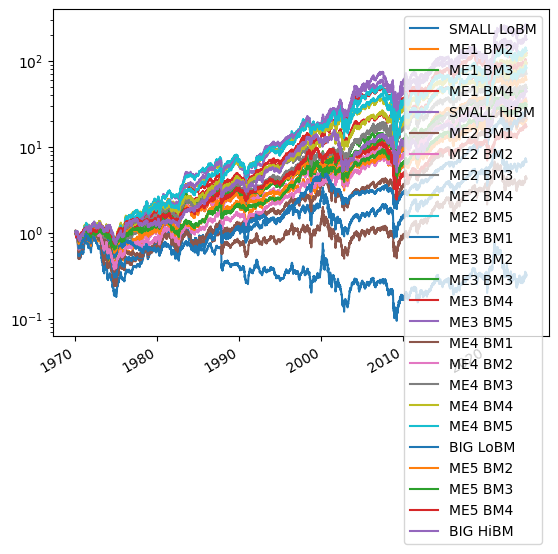

In [51]:
portfolios_xs_r.add(1).cumprod().plot(logy=True);

In [52]:
calc_sharpe(
    weights=ew_weights,
    excess_ret=portfolios_xs_r,
    rf_rate=rf,
    factor_annualize=252,
)

0.4725413421710551

In [53]:
calc_sharpe(
    weights=mv_weights,
    excess_ret=portfolios_xs_r,
    rf_rate=rf,
    factor_annualize=252,
)

0.5665351912797091

In [54]:
calc_sharpe(
    weights=min_var_weights,
    excess_ret=portfolios_xs_r,
    rf_rate=rf,
    factor_annualize=252,
)

0.765509180151553

## 1.3.

In [55]:
split_date = portfolios_xs_r.index[len(portfolios_xs_r) // 2]

training_data = TrainingData(
    simple_excess_returns=portfolios_xs_r.loc[:split_date],
)

ew_strategy.fit(training_data)
mv_strategy.fit(training_data)
min_var_strategy.fit(training_data)

ew_weights = ew_strategy(prediction_data)
mv_weights = mv_strategy(prediction_data)
min_var_weights = min_var_strategy(prediction_data)

In [56]:
min_var_strategy.cov_estimator.best_alpha

np.float64(0.010101010101010102)

In-sample.

In [57]:
calc_sharpe(
    weights=ew_weights,
    excess_ret=portfolios_xs_r.loc[:split_date],
    rf_rate=rf,
    factor_annualize=252,
)

0.48494823943017434

In [58]:
calc_sharpe(
    weights=mv_weights,
    excess_ret=portfolios_xs_r.loc[:split_date],
    rf_rate=rf,
    factor_annualize=252,
)

1.1168961074229355

In [59]:
calc_sharpe(
    weights=min_var_weights,
    excess_ret=portfolios_xs_r.loc[:split_date],
    rf_rate=rf,
    factor_annualize=252,
)

1.1536465999498693

Out-of-sample.

In [60]:
calc_sharpe(
    weights=ew_weights,
    excess_ret=portfolios_xs_r.loc[split_date:],
    rf_rate=rf,
    factor_annualize=252,
)

0.05686733711217943

In [61]:
calc_sharpe(
    weights=mv_weights,
    excess_ret=portfolios_xs_r.loc[split_date:],
    rf_rate=rf,
    factor_annualize=252,
)

0.2175170336909134

In [62]:
calc_sharpe(
    weights=min_var_weights,
    excess_ret=portfolios_xs_r.loc[split_date:],
    rf_rate=rf,
    factor_annualize=252,
)

0.196581737223829

Factor => Doesn't improve, as should've shorted

## 1.4

In [63]:
from wufam.metrics.grs_test import GRSTest

grs_test_capm = GRSTest()
grs_test_capm.fit(
    rets_df=portfolios_xs_r,
    factors_df=factors_df[["Mkt-RF"]],
)

In [64]:
grs_test_capm.grs_stat, grs_test_capm.p_value

(np.float64(5.172736447743326), np.float64(5.979218789267349e-16))

Try monthly

In [65]:
from wufam.metrics.grs_test import GRSTest

grs_test_ff = GRSTest()
grs_test_ff.fit(
    rets_df=portfolios_xs_r,
    factors_df=factors_df,
)

In [66]:
grs_test_ff.grs_stat, grs_test_ff.p_value

(np.float64(4.763956912290604), np.float64(3.769773520283761e-14))

In [67]:
long_columns = [col for col in portfolios_xs_r.columns if "HiBM" in col]
short_columns = [col for col in portfolios_xs_r.columns if "LoBM" in col]

repl = portfolios_xs_r[long_columns].mean(axis=1) - portfolios_xs_r[short_columns].mean(
    axis=1
)

In [68]:
np.abs(factors_df["HML"].to_numpy() - repl.round(4).to_numpy()).mean()

np.float64(0.0022147646168264724)

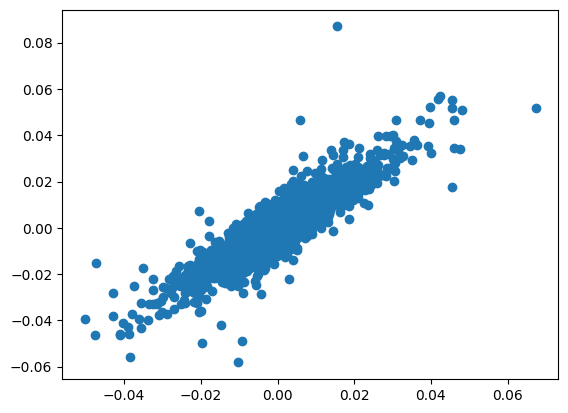

In [81]:
import matplotlib.pyplot as plt

plt.scatter(factors_df["HML"].to_numpy(), repl.round(4).to_numpy());

In [82]:
np.corrcoef(factors_df["HML"].to_numpy(), repl.round(4).to_numpy())

array([[1.        , 0.88858189],
       [0.88858189, 1.        ]])

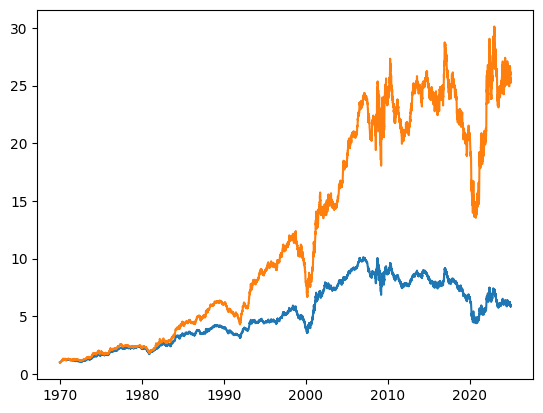

In [83]:
plt.plot(factors_df["HML"].add(1).cumprod())
plt.plot(repl.round(4).add(1).cumprod())
plt.show()

In [87]:
mkt_full = factors_df[["Mkt-RF"]].add(rf, axis=0)

In [88]:
mkt_repl = portfolios_total_r.mean(axis=1)

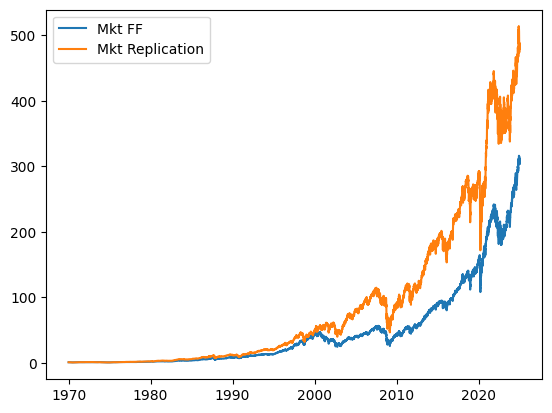

In [89]:
plt.plot(mkt_full.add(1).cumprod(), label="Mkt FF")
plt.plot(mkt_repl.add(1).cumprod(), label="Mkt Replication")
plt.legend()
plt.show()

In [76]:
np.corrcoef(mkt_repl.to_numpy().flatten(), mkt_full.to_numpy().flatten())

array([[1.        , 0.94081322],
       [0.94081322, 1.        ]])